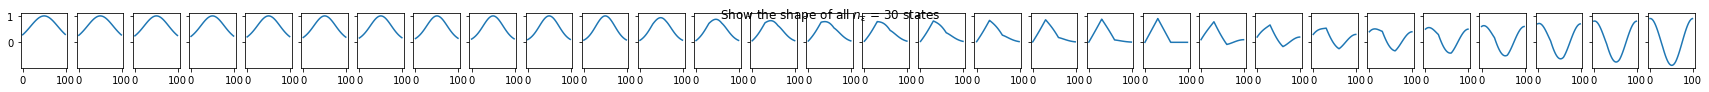

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import math
from sklearn.decomposition import PCA
import plotly.express as px
from MRA_generate import MRA_generate
from symae_model import SymAE
from parameters import *
from latent import latent
from redatuming import redatuming
from plot_redatuming import plot_redatuming
def f(n,x):
    if n==0:
        return math.e**(-5*(x-0.5)**2)
    elif n==1:
        return math.e**(-10*(x-0.5)**2)
    elif n==2:
        if x<0.3:
            return 3*x
        elif x<0.6:
            return 3*(0.6-x)
        else:
            return 0
    elif n==3:
        return math.cos(2*math.pi*x)
    elif n==4:
        return int(x<0.5)
    else:
        return np.inf
def g(n,x):
    s = n//10
    a = (n%10)/10
    if s<=3:
        return (1-a)*f(s,x)+a*f(s+1,x)
    if s==4:
        return (1-a)*f(4,x)+a*f(0,x)
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(ne,1))
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)
MRA_training = MRA_generate(d,nt,N,sigma,ne,g,replace=0)
pca_cb = PCA(n_components=2)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=0)
MRA_training.generate_default()
MRA_pca.generate_default()
X = MRA_training.X
clear_output()
N_shifts = MRA_pca.shifts.reshape(-1,1)
N_states = np.repeat(MRA_pca.states,nt)

In [2]:
image_list = []
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))
        if epoch % 10 == 0:
            clear_output(wait = True)
            _,Ns = latent(model,MRA_pca)
            N_reshaped = Ns.reshape(-1,q)
            pca_N = pca_cb.fit_transform(N_reshaped)
            df = pd.DataFrame(pca_N, columns = ['1st','2nd'])
            df_states = pd.DataFrame(N_states,columns=['state']).astype('object') 
            df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
            df = pd.concat([df,df_states,df_shifts],axis=1)
            fig = px.scatter(df, x='1st', y='2nd', color='state', text='shift', title='q=%d,loss=%f'%(q,logs["loss"]))
            fig.update_layout(height=400)
            fig.show()
clear_output()
fig.show()

In [3]:
model = SymAE(N,nt,d,p,q,kernel_size,filters,dropout_rate)
#model.load_weights('../checkpoint/'+'p=10,q=20')
#model.load_weights('./checkpoint/'+'p=3,q=40,ber,ne=2')
model.load_weights('./checkpoint/'+'p=3,q=40,ber,ne=50，29')
clear_output()

In [4]:
model.latentcat.drop.stddev = 0.1
model.latentcat.drop.rate = 0.5

In [ ]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
SGD = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.0,nesterov=False)
model.compile(loss='mse',optimizer=Adam)
history = model.fit(X,X,epochs=100000,verbose=0,callbacks=[CustomCallback()])

For epoch 511, loss is 0.000127.
For epoch 512, loss is 0.000129.
For epoch 513, loss is 0.000122.
For epoch 514, loss is 0.000124.
For epoch 515, loss is 0.000125.


In [ ]:
model.save_weights('./checkpoint/'+'p=3,q=40,ber,ne=30')

In [ ]:
def find(state,nuisance):
    MRA_data = MRA_generate(d,nt,1,sigma,ne,g,replace=1)
    for i in range(1000):
        MRA_data.generate_default()
        if MRA_data.states[0] != state:
            continue
        for j in range(nt):
            if MRA_data.shifts[0][j] == nuisance:
                return MRA_data, j
MRA1, t1 = find(0,40)
MRA2, t2 = find(40,84)
redatum = redatuming(model,MRA1,MRA2,t1,t2)
clear_output()
fig = plot_redatuming(redatum)

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:,0]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]
state_source = 20
nuisance_source = 0
fig, axs = plt.subplots(1, d, sharex=True, sharey=True, figsize=(4*d,4), dpi=40)
for i in range(d):
    coherent_code = enc(state_source, 0)[0: p]
    nuisance_code = enc(nuisance_source, i)[p: p+q]
    latent_code = np.concatenate([coherent_code, nuisance_code], axis=0)
    axs[i].plot(range(d), dec(latent_code))
    axs[i].set_title('%d'%i)
plt.suptitle('$\hat{X}_{s=%d \mapsto s=%d}$'%(nuisance_source, state_source), fontsize=50)
plt.subplots_adjust(top=0.6)
plt.show()
#fig.savefig('./plots/%dto%d'%(nuisance_source, state_source))

In [ ]:
dim = 2
pca = PCA(n_components=dim)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=1)
MRA_pca.generate_default()
Cs,Ns = latent(model,MRA_pca)
N_reshaped = Ns.reshape(-1,q)
N_shifts = MRA_pca.shifts.reshape(-1,1)
if dim == 3:
    pca_N = N_reshaped
    df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'][0:dim])
    df_states = pd.DataFrame(np.repeat(MRA_pca.states,nt),columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
    df = pd.concat([df,df_states,df_shifts],axis=1)
   
    fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state', text='shift')
if dim ==2:
    pca_N = pca.fit_transform(N_reshaped)
    df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'][0:dim])
    df_states = pd.DataFrame(np.repeat(MRA_pca.states,nt),columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
    df = pd.concat([df,df_states,df_shifts],axis=1)
    #df = df[df['state']==0]
    df = df[0:1000]
    fig = px.scatter(df, x='1st', y='2nd', color='state', text='shift')
    fig.update_layout(height=600, margin=dict(l=0, r=0, t=0, b=0))
fig.show()